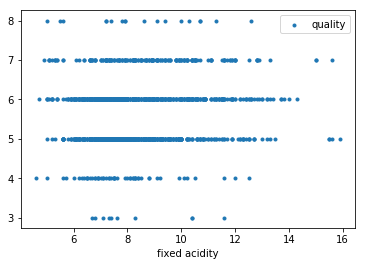

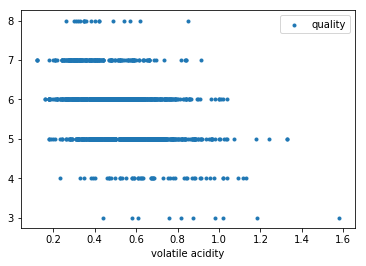

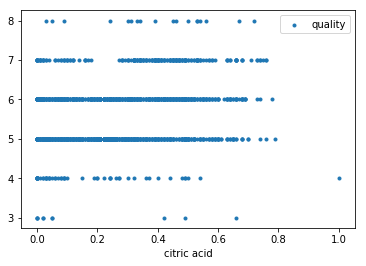

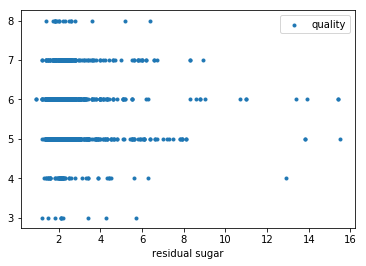

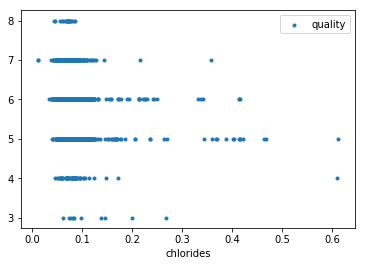

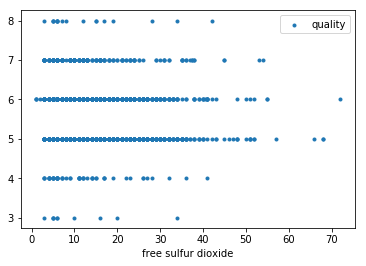

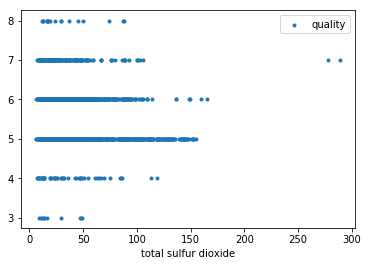

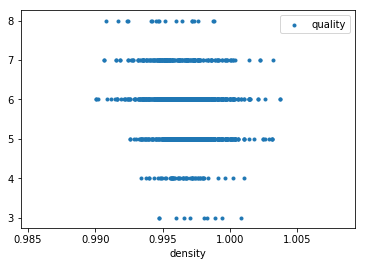

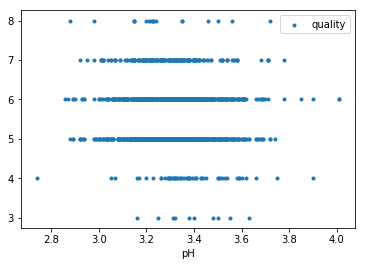

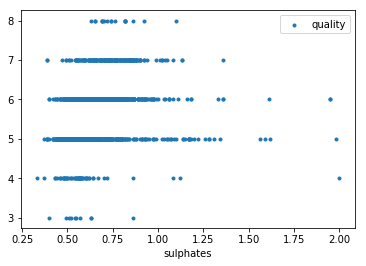

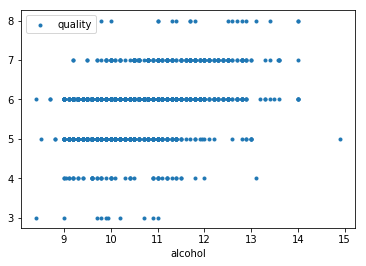

[I 2019-02-22 17:59:33,239] Finished a trial resulted in value: 0.42500000000000004. Current best value is 0.42500000000000004 with parameters: {'kernel': 'linear', 'gamma': 0.005181593829003903}.


{'kernel': 'linear', 'C': 10, 'gamma': 0.005181593829003903}
train score : 0.590687977762335
test score : 0.575


In [77]:
'''
2019/02/22 inoue hiromichi
最後の悪あがきです。
sklearnのSVCについて、optunaでチューニングしましたが、オーバーフィットしてしまいます。
train : 100%
test : 65%
ちなみに、optunaを使わないと、50%にも満たない精度でした(45%程度)

反省：
解析する前にデータを可視化して、データ構造をなんとなくでも理解してから、前処理をしないと精度が出なそう。
'''

from functools import partial
import matplotlib.pyplot as plt
import pandas as pd
import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def objective(y_train, y_test, X_train_std, X_test_std, trial):
    #目的関数
    params = {
        'kernel': trial.suggest_categorical('kernel', ['linear','rbf','sigmoid']),
        #'C': trial.suggest_loguniform('C', 10.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 3.0),
    }
    mdl = SVC(**params,C=10.0)
    mdl.fit(X_train_std, y_train)
    pred_test = mdl.predict(X_test_std)
    accuracy_test = accuracy_score(y_test, pred_test)
    return 1.0 - accuracy_test

def main():
    global target_column
    df_original = pd.read_csv("/Users/pc1013/Desktop/first/optuna_xgboost/dataframe/winequality-red.csv")
    df = preprocess(df_original)
    
    X = df.drop(target_column,axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.1, random_state = 666)
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    X_test_std = sc.transform(X_test)

    #可視化
    for key in X:
        plt.scatter(X[key],y,marker='.')
        plt.legend()
        plt.xlabel(key)
        plt.show()

    
    #optunaの前処理
    obj_f = partial(objective, y_train, y_test, X_train_std, X_test_std)
    #セッション作成
    study = optuna.create_study()
    #回数
    study.optimize(obj_f, n_trials=50)

    params = {}
    params['kernel'] = study.best_params['kernel']
    params['C'] = 10#study.best_params['C']
    params['gamma'] = study.best_params['gamma']
    
    mdl = SVC(**params)
    mdl.fit(X_train_std, y_train)
    
    pred_train = mdl.predict(X_train_std)
    accuracy_train = accuracy_score(y_train, pred_train)
    pred_test = mdl.predict(X_test_std)
    accuracy_test = accuracy_score(y_test, pred_test)
    print(params)    
    print('train score :',accuracy_train)
    print('test score :',accuracy_test)

if __name__ == '__main__':
    target_column = 'quality'
    main()
